# Exploratory Data Analysis - TripAdvisor data

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import os
import matplotlib.pyplot as plt
import requests
from wordcloud import WordCloud
from PIL import Image

%matplotlib inline
pd.set_option('display.max_columns', None)

In [37]:
def handle_duplicate_addresses(df):
    while (df[['address']].duplicated()).any():
        df.loc[df[['address']].duplicated(), 'address'] = df.loc[df[['address']].duplicated(), 'address'] + ','
        print(df.loc[df[['address']].duplicated(), 'address'].tolist())
    return df

df_post = pd.read_csv('cleaned_restaus.csv', index_col=0)
df_post = handle_duplicate_addresses(df_post)


print(len(df_post.loc[df_post[['address']].duplicated(), 'address']))


['100 Cromwell Road, London SW7 4ER England bis,', '87-135 Brompton Road, London SW1X 7XL England bis,', '87-135 Brompton Road, London SW1X 7XL England bis,', '87-135 Brompton Road, London SW1X 7XL England bis,', '1 Hamilton Place Park Lane, London W1J 7QY England bis,', '87-135 Brompton Road, London SW1X 7XL England bis,', '181 Piccadilly Fortnum & Mason, London W1A 1ER England bis,', '9 Conduit Street, London W1S 2XG England bis,', '1 Hamilton Place Park Lane, London W1J 7QY England bis,', '16 Carlos Place Mayfair, London W1K 2AL England bis,', '1 Kensington Court The Milestone Hotel, London W8 5DL England bis,']
['87-135 Brompton Road, London SW1X 7XL England bis,,', '87-135 Brompton Road, London SW1X 7XL England bis,,', '87-135 Brompton Road, London SW1X 7XL England bis,,', '1 Hamilton Place Park Lane, London W1J 7QY England bis,,']
['87-135 Brompton Road, London SW1X 7XL England bis,,,', '87-135 Brompton Road, London SW1X 7XL England bis,,,']
['87-135 Brompton Road, London SW1X 7X

In [39]:
df_post.to_csv('cleaned_restaus2.csv')

# Preprocessing

In [38]:
def freq_dict_generator(keywords, keywords_dict):
    """Creation of a dict containing all of the keywords. """
    for keyword in keywords:
        if keyword not in keywords_dict:
            keywords_dict[keyword] = 1
        else:
            keywords_dict[keyword] += 1

def col_evaluation(ls, col_name):
    """ Function used to check if a given cuisine is present in the list of the 'cuisine' column. It is
    used in a parallelised manner."""
    if col_name in ls:
        val = 1
    else:
        val = 0
    return val
            
def generate_cuisine_cols(df, cuisine_dict):
    """ Creation of the columns containing all of the cuisine types in a dataframe. """
    for col_name in cuisine_dict:
        df[col_name] = df['cuisine'].apply(lambda x: col_evaluation(x, col_name))
    return df44

def keywords_list_parser(ls):
    """Parses a given list of 3 keywords to determine the main cuisine (ex: Indian, British), the food specificity 
    (Vegan, serving seafood...) and whether the restaurant has unique features (ex: if it is a bar, a pub...). Each
     keyword is read in order to first find the specificity and the feature. For the cuisine, the algorithm first
     tries to find a 'tier one cuisine' (i.e a very specific type of cuisine) before moving on to a 'tier two cuisine' 
     (i.e a more global type of cuisine such as 'European'). For each category, a hardcoded list of entries is read. """
    
    place_type = None
    food_spec = None
    cuisine_t1 = None
    cuisine_t2 = None

    found_place = False
    found_spec = False
    found_cuisine_t1 = False
    found_cuisine_t2 = False

    place_type_ls = ['Bar', 'Pub', 'Cafe', 'Street food', 'Steakhouse']

    food_specifity = ['Vegan', 'Gluten Free Options', 'Healthy', 'Fast food', 'Barbecue', 'Seafood',
                      'Fusion', 'Contemporary', 'Halal']
    
    cuisine_tier_one = ['British', 'French', 'Italian', 'Indian', 'Spanish', 'Turkish',
                        'South American', 'Other European', 'Lebanese', 'Moroccan', 'American',
                        'Thai', 'African'] 

    cuisine_tier_two = ['Asian', 'European', 'Other European', 'Middle Eastern', 'International']
    
    for word in ls:
        
        if (word in place_type_ls) and (found_place == False):
            place_type = word
            found_place = True
        if (word in food_specifity) and (found_spec == False):
            food_spec = word
            found_spec = True
        if (word in cuisine_tier_one) and (found_cuisine_t1 == False):
            cuisine_t1 = word
            found_cuisine_t1 = True
        if (word in cuisine_tier_two) and (found_cuisine_t2 == False):
            cuisine_t2 = word
            found_cuisine_t2 = True
        
    if cuisine_t1 == None:
        cuisine = cuisine_t2
    else:
        cuisine = cuisine_t1
            
    return [cuisine, food_spec, place_type]
    

def simplify_keywords(keyword_ls, keyword_dict):
    """Simplifies keywords thanks to a hardcoded dict given as input. It is used to assemble close cuisines and 
    features into a single entry to enhance the analysis (ex : Sri Lankan and Indian are grouped)."""
    new_keyword_ls = [keyword_dict.get(item,item) for item in keyword_ls]
    return new_keyword_ls
    
def score_builder(text):
    """A unified ranking score is built by considering this formula : 
    
    score = (total_entries - rank + 1)/total_entries
    
    Therefore, restaurants ranking can be compared across different locations. """
    
    if text != 'Ranking not found':
        rank = int(text[1])
        total_entries = int(text.split()[2].replace(',',''))
        score = (total_entries - rank + 1) / total_entries
        return round(score, 3)
    else:
        return None
    
def location_extractor(text):
    """Used to extract the neighborhood where the restaurant is located."""
    if text != 'Ranking not found':
        return text.split()[-1]
    else:
        return None

def identify_coordinates(address, postcode=False):
    """This functions performs an API call with the scrapped address of the restaurant to the OpenStreetMap API.
    A longitude and a latitude are then returned."""
    
    if postcode:
        postcode = get_postcode(address)
        if postcode == None:
            return (None, None, False)
        target_url = 'https://nominatim.openstreetmap.org/search?q=' + postcode + '&format=json'
    else:
        target_url = 'https://nominatim.openstreetmap.org/search?q=' + address + '&format=json'
        
    target_url = target_url.replace(',', '%2C')
    target_url = target_url.replace(' ', '+')

    r = requests.get(target_url)
    found_coordinates = True
    if r.status_code==200:
        try:
            coordinates = r.json()[0]
            latitude, longitude = coordinates['lat'], coordinates['lon']
            
        except:
            #print(f'Address not found for: {target_url}')
            latitude, longitude = None, None
            found_coordinates = False
            
    else:
        print(f'Error {status_code} ocurred on the request')
        latitude, longitude, found_coordinates = None, None, False
    return latitude, longitude, found_coordinates 
    
def get_postcode(address):
    f = lambda x, y: x+' '+y
    splits = address.split(' ')
    splits_lagged = splits[1:] + ['']
    total_splits = set(map(f, splits, splits_lagged))
    postcode_ls = [split for split in total_splits if (split.upper() == split) and (len(split)>=7 and len(split)<=9)]
    if postcode_ls == []:
        postcode = None
    else:
        postcode = postcode_ls[0]
    return postcode

def haversine_dist_to_bokan(lat, lon):
    """Computes the Haversine distance of a given restaurant to the Bokan, given a longitude and a latitude."""

    deg_to_rad = lambda x: x * np.pi/180
    
    bokan_lat = 51.501244
    bokan_lon = -0.023363
    
    R = 6371 # Radius of the earth in km
    deg_lat = deg_to_rad(lat - bokan_lat)
    deg_lon = deg_to_rad(lon - bokan_lon) 
    a = np.sin(deg_lat/2) * np.sin(deg_lat/2) + np.cos(deg_to_rad(lat)) * np.cos(deg_to_rad(bokan_lat)) * np.sin(deg_lon/2) * np.sin(deg_lon/2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = R * c ## Distance in km
    return np.round(d, 3)

def process_distances(df, print_output=100):
    """Determines all of the distances between the restaurants and the bokan. It also returns the number of 
    restaurants which address couldn't be used to find the latitude and the longitude."""
    adress_list = df['address'].tolist()
    not_found_counter = 0
    for counter, address in enumerate(adress_list):
        lat, lon, found_coordinates = identify_coordinates(address)
        if found_coordinates == False:
            lat, lon, found_coordinates = identify_coordinates(address, postcode=True)
            if found_coordinates == False:  
                not_found_counter += 1
        if counter%print_output == 0:
            print(f'{counter}/{len(df)} restaurant coordinates have been processed.')
        adress_list[counter] = [lat, lon]
    print(f'Finished determining coordinates. {not_found_counter}/{len(df)} coordinates have not been found.')
    
    np_coords = np.asarray(adress_list, dtype=np.float32)
    np_lat, np_lon = np_coords[:,0], np_coords[:,1]
    distances = haversine_dist_to_bokan(np_lat, np_lon)

    return distances

def handle_duplicate_addresses(df):
    while (df[['address']].duplicated()).any():
        df.loc[df[['address']].duplicated(), 'address'] = df.loc[df[['address']].duplicated(), 'address'] + ','
    return df
    

def cleaning_pipeline(df, keywords_renaming_dict, parse_distances=False):
    """Performs all of the cleaning operations. The process_distances parameter is set on False by default as the 
    number of API calls can run for a substantial amount of time."""
    cuisine_dict = {}
    df_restaurants_cuisine = df.copy()
    df_restaurants_cuisine = df_restaurants_cuisine.rename(columns={'cuisine':'keywords'})                                                                                   
    # Creates a frequency dictionary containing the occurence of all types of cuisine
    df_restaurants_cuisine['keywords'].apply(lambda x: freq_dict_generator(x, cuisine_dict))
    
    # Converting reviews as int
    df_restaurants_cuisine['nb_reviews'] = df_restaurants_cuisine['nb_reviews'].str.replace(',','').astype('int64')
    
    # Creates a ranking score in order to compare restaurants competing among a different amount of restaurants
    # in a neighborhood. The score of the restaurant ranked i among n restaurants is as such : 
    # Score = (n - i + 1) / n
    df_restaurants_cuisine['score'] = df_restaurants_cuisine['ranking'].apply(lambda x: score_builder(x))
    
    # Extracts the neighborhood where the restaurant is located
    df_restaurants_cuisine['neighborhood'] = df_restaurants_cuisine['ranking'].apply(lambda x: location_extractor(x))
    
    # Simplifies and groups the original keywords to enhance the analysis
    df_restaurants_cuisine['keywords'] = df_restaurants_cuisine['keywords'].apply(lambda x: simplify_keywords(x, 
                                                                                            keywords_renaming_dict))
    # Separates the keywords into useful categories used to performed detailled analysis
    df_restaurants_cuisine['cuisine'] = None
    df_restaurants_cuisine['food_specificity'] = None
    df_restaurants_cuisine['place_type'] = None
    key_res = df_restaurants_cuisine['keywords'].apply(keywords_list_parser)
    df_restaurants_cuisine[['cuisine','food_specificity','place_type']] = pd.DataFrame(key_res.tolist(), index=df_restaurants_cuisine.index)
    
    
    # Computes the distance in kilometers between the Bokan and the scrapped restaurant
    if parse_distances:
        df_restaurants_cuisine['distance_to_bokan'] = process_distances(df_restaurants_cuisine)
    
    df_restaurants_cuisine = handle_duplicate_addresses(df_restaurants_cuisine)
    # Used to generate the columns indicating the cuisine of the restaurant - DEPRECATED
    #df_restaurants_cuisine = generate_cuisine_cols(df_restaurants_cuisine, cuisine_dict)
    
    return df_restaurants_cuisine, cuisine_dict

def cuisine_stats(df, target_col='cuisine', stats='mean', 
                  cols=['cuisine', 'nb_reviews', 'min_price', 'max_price', 'rating', 'score', 'neighborhood']):
    """ Generate statistics on restaurants, using a column such as the type of cuisine or the special features. """
    df_res = df[cols].groupby(by=target_col)
    temp = df_res.size()
    if stats == 'mean':
        df_res = df_res.mean()
        rename_dict = {col:'mean_' + col for col in df_res.columns}
    elif stats == 'median':
        df_res = df_res.median()
        rename_dict = {col:'median_' + col for col in df_res.columns}
    elif stats == 'std':
        df_res = df_res.std()
        rename_dict = {col:'std_' + col for col in df_res.columns}
    df_res = df_res.rename(columns=rename_dict)
    df_res['nb_restaus'] = temp.tolist()
    cols = df_res.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    df_res = df_res[cols]
#     f = lambda x: cuisine_name if x==1 else 'Other cuisines'
#     df_res.index = list(map(f, df_res.index))
    return df_res

In [3]:
root_path = os.path.join('../../', 'scraper', 'scraped_data', 'merged_data')

#restaurants_path = os.path.join(root_path, 'merged_restaurants.json')
restaurants_path = 'restaurants_run_1.json'
review_path = os.path.join(root_path, 'merged_reviews.json')
users_path = os.path.join(root_path, 'merged_users.json')

df_restaurants = pd.read_json(restaurants_path, lines=True)
restaurants = list(df_restaurants['restaurant_id'])
df_restaurants = df_restaurants.set_index('restaurant_id')

df_reviews = pd.read_json(review_path, lines=True)
df_users = pd.read_json(users_path, lines=True)


In [4]:
keywords_renaming_dict = {
    'Southern-Italian':'Italian', 'Sicilian':'Italian', 'Tuscan':'Italian', 'Neapolitan':'Italian',
    'Central-Italian':'Italian', 'Pizza':'Italian', 'Polish':'European', 'Belgian':'European',
    'German':'European', 'Eastern European':'European', 'Portuguese':'European',
    'Greek':'European', 'Hong Kong':'Chinese','Cantonese':'Chinese', 'Sushi':'Japanese', 
    'Malaysian':'Asian', 'Tibetan':'Asian', 'Vietnamese':'Asian', 'Latin':'South American', 
    'Argentinian':'South American', 'Mexican':'South American', 'Brazilian':'South American',
    'Colombian':'South American', 'Vegetarian Friendly':'Vegan', 'Vegan Options':'Vegan', 'Persian':'Middle Eastern',
    'Afghani':'Middle Eastern', 'Deli':'Indian', 'Sri Lankan':'Indian', 'Pakistani':'Indian', 'Balti':'Indian',
    'Nepalese':'Indian', 'Jamaican':'African', 'Carribean':'African', 'Cajun & Creole':'African',
    'Moroccan':'African', 'Brew Pub':'Pub', 'Gastropub':'Pub', 'Grill':'Barbecue'}

df_restaurants_cuisine, cuisine_dict = cleaning_pipeline(df_restaurants, keywords_renaming_dict, parse_distances=True)

0/13405 restaurant coordinates have been processed.
100/13405 restaurant coordinates have been processed.
200/13405 restaurant coordinates have been processed.
300/13405 restaurant coordinates have been processed.
400/13405 restaurant coordinates have been processed.
500/13405 restaurant coordinates have been processed.
600/13405 restaurant coordinates have been processed.
700/13405 restaurant coordinates have been processed.
800/13405 restaurant coordinates have been processed.
900/13405 restaurant coordinates have been processed.
1000/13405 restaurant coordinates have been processed.
1100/13405 restaurant coordinates have been processed.
1200/13405 restaurant coordinates have been processed.
1300/13405 restaurant coordinates have been processed.
1400/13405 restaurant coordinates have been processed.
1500/13405 restaurant coordinates have been processed.
1600/13405 restaurant coordinates have been processed.
1700/13405 restaurant coordinates have been processed.
1800/13405 restaurant 

In [5]:
print(cuisine_dict)

{'Grill': 302, 'Pakistani': 86, 'Afghani': 31, 'Indian': 1567, 'Asian': 2123, 'Vegetarian Friendly': 3163, 'Steakhouse': 212, 'Argentinian': 35, 'Latin': 64, 'Bar': 1691, 'Pizza': 1066, 'British': 3037, 'Italian': 1475, 'Deli': 88, 'Lebanese': 259, 'Cafe': 1384, 'Mediterranean': 1448, 'European': 1602, 'Balti': 295, 'Spanish': 155, 'Vegan Options': 573, 'International': 367, 'Contemporary': 159, 'Japanese': 421, 'Middle Eastern': 552, 'Sushi': 313, 'Thai': 357, 'Healthy': 212, 'Nepalese': 60, 'French': 311, 'Gluten Free Options': 205, 'Fast food': 926, 'Chinese': 638, 'Cantonese': 140, 'African': 66, 'Moroccan': 46, 'Turkish': 469, 'Persian': 97, 'Seafood': 405, 'Barbecue': 190, 'Pub': 1148, 'Caribbean': 123, 'Mexican': 106, 'Brazilian': 53, 'Bakeries': 4, 'Fusion': 79, 'Brew Pub': 47, 'Sri Lankan': 56, 'Greek': 111, 'Polish': 41, 'Eastern European': 58, 'Belgian': 12, 'German': 20, 'Sicilian': 15, 'Southern-Italian': 13, 'Tibetan': 3, 'American': 419, 'Gastropub': 51, 'Street Food': 5

## Visualisation of a restaurant's reviews

In [6]:
restaurant_id = "0"
while (restaurant_id not in restaurants):
    try:
        restaurant_id = int(input("Enter restaurant id from 1 to 143 : "))
    except:
        print("Please enter int")

Enter restaurant id from 1 to 143 : 5


### TF-IDF matrix

In [7]:
target_csv = str(restaurant_id) + '_word_freq.csv'
target_csv_path = os.path.join('..', 'cleaned_data', 'restaurants_tfidf', target_csv)

df_tfidf = pd.read_csv(target_csv_path, index_col=0)

In [8]:
df_tfidf.head()

10       150   18   20  2nd   30  30pm   35   40   43  4th   51  \
review_id                                                                     
34034      0.0  0.000000  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0   
34035      0.0  0.000000  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0   
34036      0.0  0.000000  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0   
34038      0.0  0.161671  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0   
34044      0.0  0.000000  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0   

            60  able  absolute  absolutely  accommodate  accompany  \
review_id                                                            
34034      0.0   0.0       0.0         0.0          0.0        0.0   
34035      0.0   0.0       0.0         0.0          0.0        0.0   
34036      0.0   0.0       0.0         0.0          0.0        0.0   
34038      0.0   0.0       0.0         0.0          0.0        0.0   
34044      0.0   0.0       0.0         0.0          0.0        0.0   

           accpommodating  actually  add  addition  advance  affordable  \
review_id                                                                 
34034                 0.0       0.0  0.0       0.0      0.0         0.0   
34035                 0.0       0.0  0.0       0.0      0.0         0.0   
34036                 0.0       0.0  0.0       0.0      0.0         0.0   
34038                 0.0       0.0  0.0       0.0      0.0         0.0   
34044                 0.0       0.0  0.0       0.0      0.0         0.0   

           africa  ago  agree  ahead  amaze  amazing  amazingly  ambiance  \
review_id                                                                   
34034         0.0  0.0    0.0    0.0    0.0      0.0   0.000000       0.0   
34035         0.0  0.0    0.0    0.0    0.0      0.0   0.000000       0.0   
34036         0.0  0.0    0.0    0.0    0.0      0.0   0.269238       0.0   
34038         0.0  0.0    0.0    0.0    0.0      0.0   0.000000       0.0   
34044         0.0  0.0    0.0    0.0    0.0      0.0   0.000000       0.0   

           ambience  amorossa  anari  andrea  andreas  aniri  aniseed  \
review_id                                                               
34034           0.0       0.0    0.0     0.0      0.0    0.0      0.0   
34035           0.0       0.0    0.0     0.0      0.0    0.0      0.0   
34036           0.0       0.0    0.0     0.0      0.0    0.0      0.0   
34038           0.0       0.0    0.0     0.0      0.0    0.0      0.0   
34044           0.0       0.0    0.0     0.0      0.0    0.0      0.0   

           anniversary  apparently  appetiser  area  arm  array  arrive  \
review_id                                                                 
34034              0.0         0.0        0.0   0.0  0.0    0.0     0.0   
34035              0.0         0.0        0.0   0.0  0.0    0.0     0.0   
34036              0.0         0.0        0.0   0.0  0.0    0.0     0.0   
34038              0.0         0.0        0.0   0.0  0.0    0.0     0.0   
34044              0.0         0.0        0.0   0.0  0.0    0.0     0.0   

           artichoke  artistic  ask  ate  atmosphere  attention  attentive  \
review_id                                                                    
34034            0.0       0.0  0.0  0.0    0.000000   0.000000   0.000000   
34035            0.0       0.0  0.0  0.0    0.118894   0.000000   0.122665   
34036            0.0       0.0  0.0  0.0    0.000000   0.000000   0.000000   
34038            0.0       0.0  0.0  0.0    0.000000   0.161671   0.000000   
34044            0.0       0.0  0.0  0.0    0.000000   0.000000   0.000000   

           aubergine  authentic  authentically  available  average  await  \
review_id                                                                   
34034            0.0        0.0            0.0        0.0      0.0    0.0   
34035            0.0        0.0            0.0        0.0      0.0    0.0   
34036   

In [9]:
df_tfidf_mean = df_tfidf.mean().sort_values(ascending=False).to_frame(name='tfidf mean')
df_tfidf_mean.head()

tfidf mean
food          0.070914
restaurant    0.051776
service       0.048836
great         0.047972
delicious     0.043585

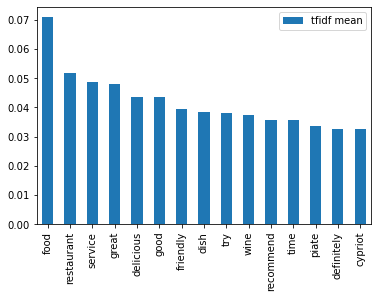

In [10]:
df_tfidf_mean[:15].plot(kind='bar')
plt.show()

### Wordcloud visualisation

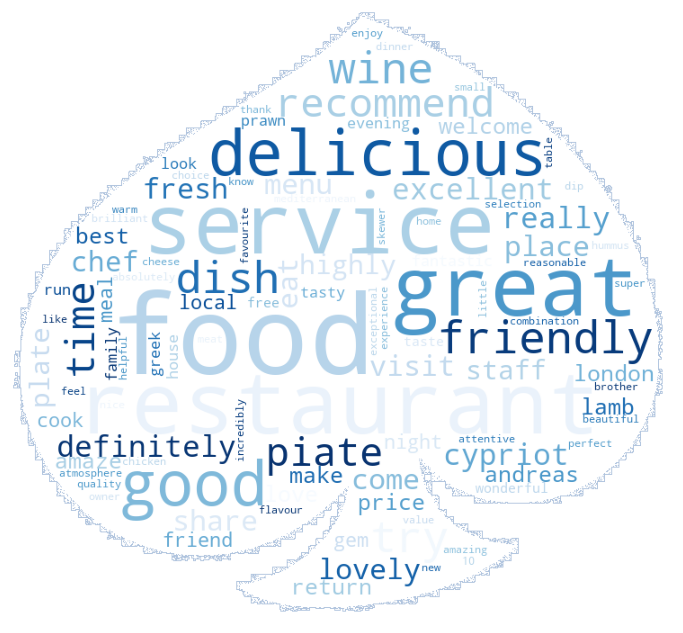

In [11]:
target_img = str(restaurant_id) + '_word_cloud.png'
target_img_path = os.path.join('..', 'cleaned_data', 'restaurant_wordclouds', target_img)
img = plt.imread(target_img_path)

plt.figure(figsize=(12,16))
plt.imshow(img)
plt.axis("off")
plt.show()

Other wordclouds and TF-IDF can be found in the dedicated folder

# Global restaurant analysis

In [12]:
# def filtering_dataframe(df, column, terms):
    
#     df = df[df[''].str.findall()]
#     return df

# def generate_wordcloud(df, idx, directory, mask):
#     #filename = directory + str(idx) + "_word_cloud.png"

#     df_mean = df.mean().sort_values(ascending=False).to_frame(name='tfidf mean')
#     dict_words_tfidf = df_mean[df_mean['tfidf mean'] != 0].to_dict()['tfidf mean']

#     wordcloud = WordCloud(height=600, width=800, background_color="white",
#         colormap='Blues', max_words=100, mask=mask,
#         contour_width=0.5, contour_color='lightsteelblue')
#     wordcloud.generate_from_frequencies(frequencies=dict_words_tfidf)
#     wordcloud.to_file(filename)  

In [17]:
df_restaurants_cuisine.head(10)

name  \
restaurant_id                                 
1                         Taste Of Peshawar   
16                   Orpington Citi Kitchen   
19             4 Locos Argentine Steakhouse   
17                      La Plata Steakhouse   
22                         Madhu's Heathrow   
18                               Revolution   
21                                Melucci's   
20                            Tamara Lounge   
23                                  Madhu's   
15                                    Sidra   

                                                    resto_TA_url  nb_reviews  \
restaurant_id                                                                  
1              https://www.tripadvisor.co.uk/Restaurant_Revie...         171   
16             https://www.tripadvisor.co.uk/Restaurant_Revie...         146   
19             https://www.tripadvisor.co.uk/Restaurant_Revie...         139   
17             https://www.tripadvisor.co.uk/Restaurant_Revie...         221   
22             https://www.tripadvisor.co.uk/Restaurant_Revie...         637   
18             https://www.tripadvisor.co.uk/Restaurant_Revie...        1289   
21             https://www.tripadvisor.co.uk/Restaurant_Revie...         277   
20             https://www.tripadvisor.co.uk/Restaurant_Revie...         684   
23             https://www.tripadvisor.co.uk/Restaurant_Revie...         528   
15             https://www.tripadvisor.co.uk/Restaurant_Revie...         140   

               min_price  max_price  \
restaurant_id                         
1                    2.0        3.0   
16                   2.0        3.0   
19                   2.0        3.0   
17                   2.0        3.0   
22                   2.0        3.0   
18                   2.0        3.0   
21                   2.0        3.0   
20                   2.0        3.0   
23                   2.0        3.0   
15                   1.0        1.0   

                                                   keywords  \
restaurant_id                                                 
1                        [Barbecue, Indian, Middle Eastern]   
16                                   [Indian, Asian, Vegan]   
19                      [Steakhouse, South American, Vegan]   
17             [Steakhouse, South American, South American]   
22                                   [Indian, Asian, Vegan]   
18                                  [Bar, Italian, British]   
21                                 [Italian, Indian, Vegan]   
20                                   [Indian, Asian, Vegan]   
23                                [Indian, Asian, Barbecue]   
15                          [Lebanese, Cafe, Mediterranean]   

                                                         address  \
restaurant_id                                                      
1                        62 Harrow Road, Wembley HA9 6PL England   
16             82 Cotmandene Crescent, Orpington, Bromley BR5...   
19             6-8 Tudor Court- Russell Hill Road, Purley CR8...   
17             East Sheen 109 Sheen Lane, Richmond SW14 8AE E...   
22             Bath Road Sheraton Skyline Hotel London Heathr...   
18             4 Whittaker Avenue Richmond, Richmond TW9 1EH ...   
21                 55 Bexley High Street, Bexley DA5 1AB England   
20                      Uxbridge Road, Uxbridge UB10 0NA England   
23               39 South Road, Southall, Ealing UB1 1SW England   
15             5 Church Road, Teddington, Richmond TW11 8PF E...   

                   phone_number              website              menu  \
restaurant_id                                                            
1              +44 20 3015 4133  Website not scraped  Menu not scraped   
16             +44 20 8302 2222  Website not scraped  Menu not scraped   
19             +44 20 8660 5200  Website not scraped  Menu not scraped   
17             +44 20 8876 7747  Website not scraped  Menu not scraped   
22             +44 20 8564

In [14]:
df_restaurants_cuisine.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13405 entries, 1 to 14194
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               13405 non-null  object 
 1   resto_TA_url       13405 non-null  object 
 2   nb_reviews         13405 non-null  int64  
 3   min_price          10669 non-null  float64
 4   max_price          10669 non-null  float64
 5   keywords           13405 non-null  object 
 6   address            13405 non-null  object 
 7   phone_number       12554 non-null  object 
 8   website            13405 non-null  object 
 9   menu               13405 non-null  object 
 10  ranking            13405 non-null  object 
 11  rating             13405 non-null  float64
 12  score              2809 non-null   float64
 13  neighborhood       2809 non-null   object 
 14  cuisine            10237 non-null  object 
 15  food_specificity   5113 non-null   object 
 16  place_type         340

In [15]:
df_stats = cuisine_stats(df_restaurants_cuisine, stats='mean')
df_stats.head(20)

nb_restaus  mean_nb_reviews  mean_min_price  mean_max_price  \
cuisine                                                                       
African                128       215.000000        1.810811        2.567568   
American               379       295.474934        1.874598        2.614148   
Asian                  835       196.194012        1.961686        2.720307   
British               2849       300.309231        1.919579        2.636227   
European               528       207.589015        1.985263        2.736842   
French                 287       529.926829        2.342105        3.075188   
Indian                1662       148.475933        1.919643        2.756868   
International          165       195.648485        2.006757        2.770270   
Italian               1805       221.200000        1.908010        2.703379   
Lebanese               250       155.324000        1.819820        2.612613   
Middle Eastern         225       111.048889        1.829016        2.626943   
South American         226       338.845133        1.966507        2.645933   
Spanish                131       342.770992        2.046875        2.976562   
Thai                   348       185.316092        1.905660        2.764151   
Turkish                419       148.436754        1.742297        2.434174   

                mean_rating  mean_score  
cuisine                                  
African            3.878906    0.967447  
American           3.597625    0.992537  
Asian              3.905988    0.981865  
British            4.042998    0.975848  
European           3.943182    0.984545  
French             4.137631    0.992164  
Indian             3.812575    0.968931  
International      4.051515    0.983538  
Italian            3.894737    0.981463  
Lebanese           4.108000    0.990105  
Middle Eastern     4.091111    0.991615  
South American     4.057522    0.987000  
Spanish            4.152672    0.992519  
Thai               3.987069    0.962308  
Turkish            3.834129    0.975549

In [16]:
df_restaurants_cuisine.to_csv('cleaned_restaus.csv')